# In order to get this milestone to work, the images from the Flickr-8k dataset should be placed in a directory called "Images" in the Milestone_4 directory.

# Part 1, Projection head

In [2]:
import torch
import random
import torchvision
import os
import numpy
from xml.dom import minidom
from matplotlib import pyplot as plt
import psycopg2
import os

In [3]:
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-twitter-200')
glove_vectors.most_similar('capitalism')

[('socialism', 0.8253527879714966),
 ('communism', 0.7220152020454407),
 ('democracy', 0.6800484657287598),
 ('capitalist', 0.6743904948234558),
 ('crony', 0.6574956774711609),
 ('fascism', 0.6154928803443909),
 ('ideology', 0.6098697185516357),
 ('imperialism', 0.6093625426292419),
 ('marxism', 0.5975797772407532),
 ('poverty', 0.5796671509742737)]

In [4]:
print(len(glove_vectors["capitalism"]))

200


In [5]:
captions = open("captions_reduced.txt", "r")
caption_lines = captions.readlines()
captions.close()

/home/msbean/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


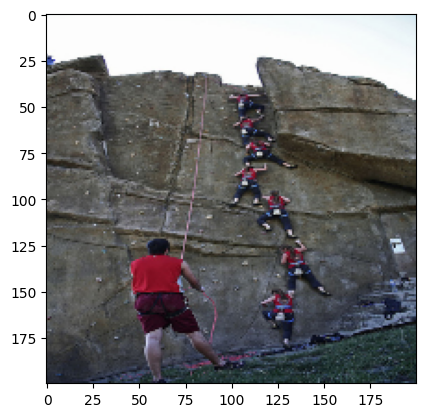

In [6]:
for i in range(10):
    image_path = "Images/" + random.choice(caption_lines).split(",")[0]
    image = torchvision.io.read_image(image_path)
    transform = torchvision.transforms.Resize([200, 200])
    image = transform(image)
    print(image.size())
    plt.imshow(image.permute(1, 2, 0))


In [8]:
#This generates image encodings. It is just milestone 2 with a few tweaks.
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.compress = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
        )
        self.decompress = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False)
        )
         
    def forward(self, input):
        return self.decompress(self.compress(input))
    
cnn = CNN()
gpu = torch.device('cuda') 
cnn.to(gpu)


CNN(
  (compress): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decompress): Sequential(
    (0): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
  )
)

In [27]:
import os

adam = torch.optim.Adam(cnn.parameters(), lr=0.00001)
loss_function = torch.nn.MSELoss()


i=0
while i < 20000:
    try:
        video_index = str(random.randint(0,49))
        num_frames = len(os.listdir("../video_indexing/video_frames/" + video_index + "_frames/"))
        image_path = "../video_indexing/video_frames/" + video_index + "_frames/" + "out" + str(random.randint(1,num_frames)) + ".jpg"
        image = torchvision.io.read_image(image_path)
        image = image.float()
        image /= 256
        transform = torchvision.transforms.Resize([200, 200])
        frame = transform(image)
    except Exception as e:
        print(e)
        continue

    frame = frame.to(gpu)

    output = cnn(frame)
    loss = loss_function(output, frame)
    print(loss)
    loss.backward()

    adam.step()
    adam.zero_grad()
    i += 1
    
torch.save(cnn.state_dict(), 'cnn.pth')


tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=

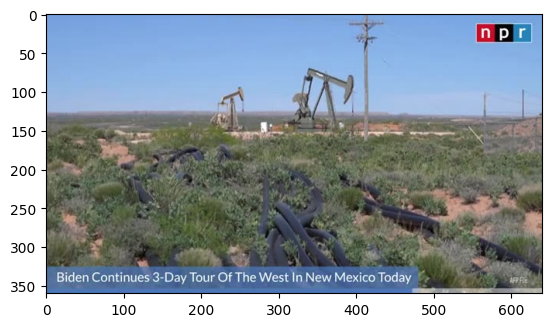

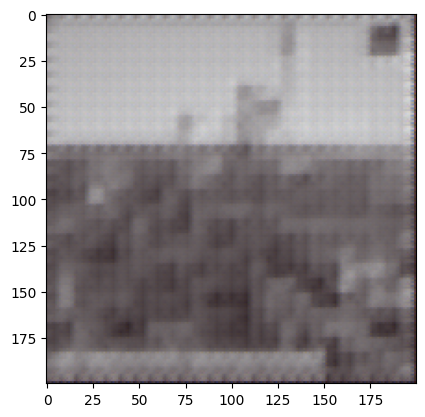

In [9]:
cnn.load_state_dict(torch.load("./cnn.pth"))

video_index = str(random.randint(0,49))
num_frames = len(os.listdir("../video_indexing/video_frames/" + video_index + "_frames/"))
image_path = "../video_indexing/video_frames/" + video_index + "_frames/" + "out" + str(random.randint(1,num_frames)) + ".jpg"
image = torchvision.io.read_image(image_path)
plt.imshow(image.permute(1,2,0))
plt.show()
image = image.float()
image /= 256
transform = torchvision.transforms.Resize([200, 200])
frame = transform(image)

frame = frame.to(gpu)

output = cnn(frame).cpu().detach()

plt.imshow(output.permute(1,2,0))
video_links = open("../video_links.txt")
video_link_lines = video_links.readlines()

In [27]:
#Now to shove encodings into a database
import psycopg2
import os
#So, we're gonna insert the encodings of about 4,000 frames from the videos into the database
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 
  

cnn = CNN()
cnn.load_state_dict(torch.load("./cnn.pth"))
for i in range(50):
    video_index = str(i)
    num_frames = len(os.listdir("../video_indexing/video_frames/" + video_index + "_frames/"))
    for frame in range(num_frames):
        image_path = "../video_indexing/video_frames/" + video_index + "_frames/" + "out" + str(frame+1) + ".jpg"
        image = torchvision.io.read_image(image_path)
        image = image.float()
        image /= 256
        transform = torchvision.transforms.Resize([200, 200])
        frame = transform(image)


        output = cnn.compress(frame)

        sql = "INSERT INTO frame_embeddings (embedding, youtube_link) VALUES ('["
        flattened = output.flatten().tolist()
        for datum in flattened:
            sql += str(datum) + ","
        sql = sql[:-1]
        sql += "]',"
        sql += "'" + video_link_lines[i] + "'"
        sql += ")"
        cursor.execute(sql) 

conn.commit() 
conn.close()

/home/msbean/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
nones = 0
somes = 0
text_embeddings = [[] for i in range(50)]

for v in range(50):
    dom = minidom.parse("../videos/" + str(v) + "_captions.txt")
    for caption in dom.getElementsByTagName("s"):
        for child_node in caption.childNodes:
            if child_node.nodeType == child_node.TEXT_NODE:
                stripped = ''.join([i for i in child_node.data if i.isalpha()]).lower()
                if stripped in glove_vectors:
                    embedding = glove_vectors[stripped]
                    text_embeddings[v].append(embedding)

                    somes += 1
                else:
                    nones += 1
print(somes / (somes + nones))


0.9795010714430114


# Part 2, contrastive loss

In [11]:
import math
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        #These will project the image and text encodings to be 1875-dimensional vectors
        #So that we can take the dot product between image and text encodings
        self.project_image = torch.nn.Sequential(
            torch.nn.Flatten(1, -1),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
        self.project_text = torch.nn.Sequential(
            torch.nn.Linear(200, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
         
    #We will train the network to predict its own input by compressing and then decompressing it
    def forward(self, word_encodings, image_encodings):
        word_encodings = self.project_text(word_encodings)
        word_encodings = torch.nn.functional.normalize(word_encodings)
        image_encodings = self.project_image(image_encodings)
        image_encodings = torch.nn.functional.normalize(image_encodings)
        #The dot similarity is the dot product of a word encodnig and an image encoding
        #This works because the dot product acts a measure for similarity
        #And this matrix multiplication will get the dot product of every row in A with every row in B
        return word_encodings, image_encodings
    
cnn2 = CNN2()
cnn2.to(gpu)
cnn2.load_state_dict(torch.load("./cnn2.pth"))
training_losses = []

    

In [13]:
adam = torch.optim.Adam(cnn2.parameters(), lr=0.000001)
transform = torchvision.transforms.Resize([200, 200])

conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 

for i in range(8000):
    sql = "SELECT youtube_link, AVG(embedding) AS embedding FROM frame_embeddings GROUP BY youtube_link ORDER BY RANDOM () LIMIT 10"
    cursor.execute(sql)
    results = cursor.fetchall()

    frame_embeddings = []
    word_embeddings = []
    for result in results:
        video_index = video_link_lines.index(result[0])
        word_embedding = text_embeddings[video_index]
        word_embedding = numpy.mean(word_embedding, axis=0)
        frame_embedding = [float(s) for s in result[1][1:-1].split(",")]

        frame_embeddings.append(torch.FloatTensor(frame_embedding))
        word_embeddings.append(torch.FloatTensor(word_embedding))

    frame_embeddings = torch.stack(frame_embeddings)
    frame_embeddings = frame_embeddings.to(gpu)

    word_embeddings = torch.stack(word_embeddings)
    word_embeddings = word_embeddings.to(gpu)

    word_embeddings, frame_embeddings = cnn2.forward(word_embeddings, frame_embeddings)
    cosine_similarities = torch.matmul(frame_embeddings, torch.transpose(word_embeddings, -1, 0))
    cosine_similarities = torch.e**cosine_similarities
    diagonal = torch.diagonal(cosine_similarities)
    cosine_similarities_sum = cosine_similarities.sum(dim=1)


    similarities = diagonal/cosine_similarities_sum
    errors = -torch.log(similarities)

    errors.sum().backward()

    print(errors.sum())
    
    adam.step()
    adam.zero_grad()


    training_losses.append(errors.sum().item())


conn.commit() 
conn.close()

tensor(14.7062, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.8721, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.6611, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.9173, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.5024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.9294, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.2490, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.2266, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.6601, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.8313, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.7704, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.7355, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.8415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.8653, device='cuda:0', grad_fn=<SumBackward0>)
tensor(15.0289, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.7864, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.9483, device='cuda:0', grad_fn=<SumBackward0>)
tensor(14.9768, device='cuda:0'

KeyboardInterrupt: 

In [14]:
torch.save(cnn2.state_dict(), 'cnn2.pth')

In [22]:
#Now to shove encodings into a database
import psycopg2
import os
#So, we're gonna insert the encodings of about 4,000 frames from the videos into the database
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 
sql = "DELETE FROM projected_video_embeddings"
cursor.execute(sql)
sql = "SELECT youtube_link, AVG(embedding) AS embedding FROM frame_embeddings GROUP BY youtube_link"
cursor.execute(sql)
results = cursor.fetchall()

for result in results:
    print(result[0])
    frame_embeddings = []
    word_embeddings = []
    video_index = video_link_lines.index(result[0])
    word_embedding = random.sample(text_embeddings[video_index], 50)
    word_embedding = numpy.mean(word_embedding, axis=0)
    frame_embedding = [float(s) for s in result[1][1:-1].split(",")]

    frame_embeddings.append(torch.FloatTensor(frame_embedding))
    word_embeddings.append(torch.FloatTensor(word_embedding))


    frame_embeddings = torch.stack(frame_embeddings)
    frame_embeddings = frame_embeddings.to(gpu)

    word_embeddings = torch.stack(word_embeddings)
    word_embeddings = word_embeddings.to(gpu)

    word_embeddings, frame_embeddings = cnn2.forward(word_embeddings, frame_embeddings)
    sql = "INSERT INTO projected_video_embeddings (embedding, youtube_link) VALUES ('["
    flattened = frame_embeddings.flatten().tolist()
    for datum in flattened:
        sql += str(datum) + ","
    sql = sql[:-1]
    sql += "]',"
    sql += "'" + str(video_index) + ".mp4'"
    sql += ")"
    cursor.execute(sql) 
    print(frame_embeddings)
conn.commit() 
conn.close()

https://www.youtube.com/watch?v=0aGsDW_AOrQ

tensor([[ 0.0230, -0.0099,  0.0122,  ...,  0.0078,  0.0444,  0.0408]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.youtube.com/watch?v=ZOx0ME5jTXg

tensor([[ 0.0052,  0.0309,  0.0208,  ..., -0.0039,  0.0303,  0.0024]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.youtube.com/watch?v=nxLaX9J3ctU

tensor([[-0.0092, -0.0436, -0.0020,  ..., -0.0031, -0.0118, -0.0043]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.youtube.com/watch?v=9KwL_EICcqY

tensor([[-0.0075,  0.0164,  0.0079,  ...,  0.0321, -0.0081, -0.0191]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.youtube.com/watch?v=2e5Q53kV6yE

tensor([[ 0.0476,  0.0442, -0.0224,  ..., -0.0278,  0.0301, -0.0091]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.youtube.com/watch?v=y82Z57N0Vug

tensor([[-0.0103, -0.0266, -0.0106,  ...,  0.0297,  0.0055,  0.0173]],
       device='cuda:0', grad_fn=<DivBackward0>)
https://www.yout

In [16]:
import numpy

def encode_caption_string(caption_string):
    encodings = []
    for caption in caption_string:
        if caption in glove_vectors:
            encodings.append(glove_vectors[caption])
    if len(encodings) == 0:
        return None
    return numpy.mean(encodings, axis=0)


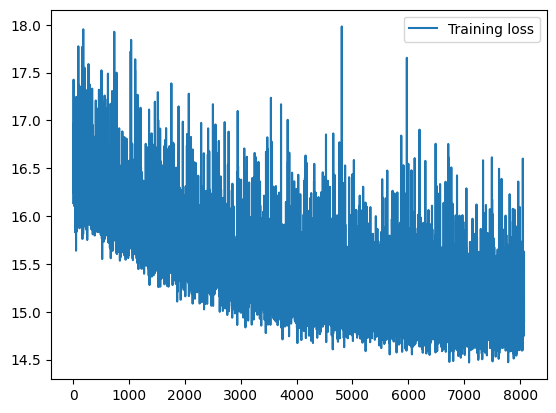

In [17]:
from matplotlib import pyplot as plt

plt.plot([i for i in range(len(training_losses))], training_losses, label="Training loss")
plt.legend()

plt.show()

In [20]:
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 

encoding = torch.stack([torch.FloatTensor(encode_caption_string("search intensifies for missing submersible as underwater the search continues and gender affirming care noises detected".split(" ")))])
encoding = encoding.to(gpu)
encoding = cnn2.project_text(encoding)

sql = "SELECT youtube_link FROM projected_video_embeddings ORDER BY embedding <-> '["
flattened = encoding.flatten().tolist()
for datum in flattened:
    sql += str(datum) + ","
sql = sql[:-1]
sql += "]' LIMIT 3"

cursor.execute(sql)
result = cursor.fetchall()
print(result)

conn.commit() 
conn.close()

[('https://www.youtube.com/watch?v=bEmhqfhpbAU\n',), ('https://www.youtube.com/watch?v=tmgfO5cB9tE\n',), ('https://www.youtube.com/watch?v=GgkLYH_8iDE\n',)]
